## Load Data and Initial Grid Search

In [8]:
# Assign directory
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'

ROOT_DIR = YASH
os.chdir(ROOT_DIR + 'testing-framework/')

DATA_NAME = 'full-pastis-gray-wavelet'
GROUP = 'layer'

# os.mkdir(DATA_NAME)
# os.mkdir(os.path.join(DATA_NAME, "CSVs"))
# os.mkdir(os.path.join(DATA_NAME, "plots"))

In [9]:
from utilities import *
from plot_utilities import *

np.random.seed(42)

In [10]:
data_df = pd.read_pickle(f'../transformed-data/{DATA_NAME}.pickle')
min_group, max_group = (min(data_df[GROUP])), max(data_df[GROUP])
group_data_map = dict()
for group in np.arange(min_group, max_group + 1):
    data = np.append(data_df[(data_df['orientation'] == 'H') & (data_df[GROUP] == group)]['data'].iloc[0],
                     data_df[(data_df['orientation'] == 'V') & (data_df[GROUP] == group)]['data'].iloc[0])
    group_data_map[group] = np.sort(data)#[np.random.permutation(data.size)[:min(data.size, 100000)]])
pd.to_pickle(group_data_map, f'{DATA_NAME}/group_data_map.pickle')

group_data_map = pd.read_pickle(f'{DATA_NAME}/group_data_map.pickle')
group_data_map

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -43.34915759, -36.2290875 , ...,  36.11999915,
         38.35812055,  42.17747737]),
 6: array([-23.87540781, -23.66829959, -23.29668418, ...,  25.41955052,
         31.52717851,  44.79754701]),
 7: array([-19.12997336, -18.52962064, -17.2224645 , ...,  16.63923718,
         17.96650462,  20.30569957]),
 8: array([-18.71256003, -17.84609759, -16.94317757, ...,  15.43083627,
         16.78232461,  20.5891778 ])}

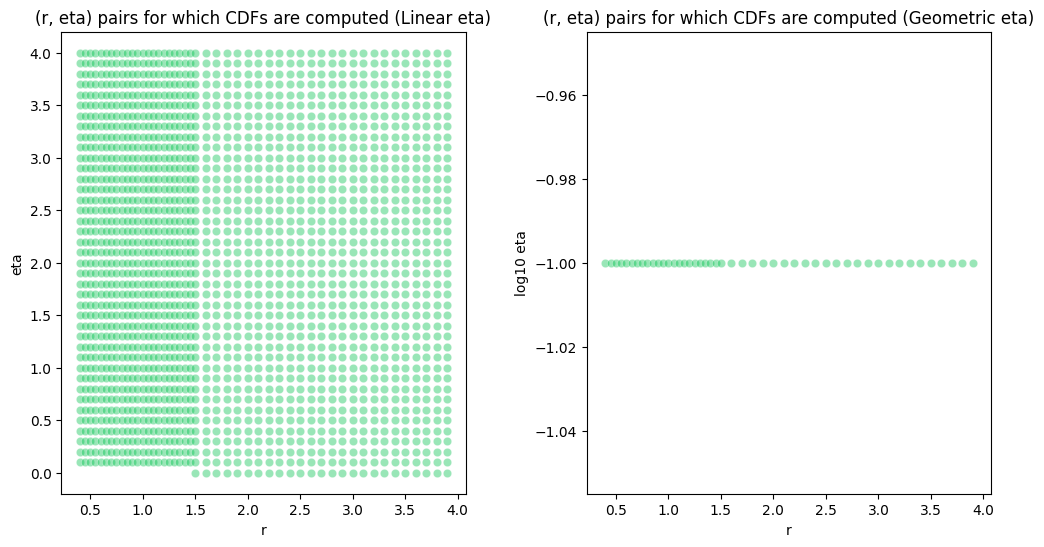

In [11]:
# Large grid search CDFs already computed (r = 0 to 8, eta = 0 to 3.9)

all_cdfs = combine_pickles('scipy_10000') | combine_pickles('mtlb_10000') 
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)

In [12]:
''' Only need to run commented code once'''

master_df = pd.DataFrame(columns = [GROUP, 'num_samples', 'initial_param', 'kstest_stat_initial', 'best_param_eta_0', 'kstest_stat_eta0'])
idx_eta0 = [i for i, param in enumerate(sorted(all_cdfs)) if np.isclose(param[1], 0, atol = 1e-40)]
sorted_params = sorted(all_cdfs)
for i, group in enumerate(np.arange(min_group, max_group+1)):
    print("Processing group (layer/band) ", group)
    sample = group_data_map[group]
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs)
    ksstats_eta0 = [ksstats[i] for i in idx_eta0]
    idx_min_ksstats_eta0 = idx_eta0[np.argmin(ksstats_eta0)]
    master_df.loc[i, :] = [group, sample.size, initial_param, min_stat, sorted_params[idx_min_ksstats_eta0], ksstats[idx_min_ksstats_eta0]]
master_df = master_df.set_index(GROUP)
master_df.to_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv', index_col=GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

Processing group (layer/band)  2
Processing group (layer/band)  3
Processing group (layer/band)  4
Processing group (layer/band)  5
Processing group (layer/band)  6
Processing group (layer/band)  7
Processing group (layer/band)  8


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0
layer,,,,,
2,3180,"(0.4, 4.0)",0.043034,"(1.5, 0)",0.464051
3,12720,"(0.45, 4.0)",0.008566,"(1.5, 0)",0.430129
4,50880,"(0.45, 1.6)",0.007633,"(1.5, 0)",0.369397
5,203520,"(0.45, 0.1)",0.006604,"(1.5, 0)",0.253220
6,814080,"(0.8, 0.2)",0.024806,"(1.5, 0)",0.099350
7,3256320,"(3.9, 0.0)",0.083084,"(3.9, 0)",0.083084
8,13025280,"(3.9, 0.0)",0.228028,"(3.9, 0)",0.228028


In [1]:
group = 4
visualize_cdf(group_data_map[group], 
              all_cdfs = all_cdfs, 
              params= master_df.loc[group, 'initial_param'], 
              n_samples=10000, interval = (-60, 40), 
              provided_loc = -50);

NameError: name 'visualize_cdf' is not defined

In [8]:
# Given that pvalue = 0.05 and I have n samples, what should the kstest statistic be?
# Note how as num_samples increases by a factor of 4, the cutoff decreases by a factor of 2
# Could potentially include the plot in `images/loglog_pvalue_numsamples.png` 

for group in np.arange(min_group, max_group+1):
    num_points = group_data_map[group].size
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = stats.kstwo(n=num_points).isf(0.05)    
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05
layer,,,,,,
2,1000,"(0.6, 3.2)",0.040880,"(0.4, 0)",0.099036,0.024030
3,1000,"(0.7, 3.4)",0.021737,"(0.4, 0)",0.111677,0.012029
4,1000,"(0.8, 3.0)",0.018113,"(0.5, 0)",0.063729,0.006018
5,1000,"(0.9, 1.4)",0.019392,"(0.6, 0)",0.051665,0.003010
6,1000,"(1.1, 0.5)",0.025748,"(0.8, 0)",0.035052,0.001505
7,1000,"(6.0, 0.0)",0.037099,"(6.0, 0)",0.037099,0.000753
8,1000,"(5.5, 0.0)",0.175988,"(5.5, 0)",0.175988,0.000376


In [14]:
r_d, eta_d = 1, 1 # Controls precision to which parameters are optimized

for group in np.arange(min_group, max_group+1): 
    sample = group_data_map[group]
    initial_param = master_df.loc[group, 'initial_param']
    master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'] = coord_descent_gengamma(sample, initial_param, r_depth = r_d, eta_depth=eta_d, layer=group)
    master_df.loc[group, 'kstest_stat_cd'] = compute_ksstat(sample, combine_pickles(f'{GROUP}{group}_10000')[(master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'])])
    print(f"{GROUP} {group} best parameters: {master_df.loc[group, 'kstest_stat_cd']}")

master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_cd'], row.loc['num_samples']), axis = 1)    
master_df[['num_samples', 'initial_param', 'kstest_stat_initial', f'best_r_d{r_d}', f'best_eta_d{eta_d}', 'kstest_stat_cd', 'n_pval_0.05']].to_csv(f'{DATA_NAME}/CSVs/optimized_params.csv')
master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

layer 2 best parameters: 0.03833820625471334
layer 3 best parameters: 0.02513933428684184
layer 4 best parameters: 0.011665613038144666
layer 5 best parameters: 0.017340770006997408
layer 6 best parameters: 0.006843837366121042
layer 7 best parameters: 0.027027241572522342
layer 8 best parameters: 0.17126654481720077


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,best_r_d4,best_eta_d2,kstest_stat_cd,best_r_d1,best_eta_d1,best_r_d2,n_pval_0.05
layer,,,,,,,,,,,,,
2,1000,"(0.6, 3.2)",0.040880,"(0.4, 0)",0.099036,0.024030,0.602,3.2,0.038338,0.6,3.2,0.6,1264
3,1000,"(0.7, 3.4)",0.021737,"(0.4, 0)",0.111677,0.012029,NaN,NaN,0.025139,0.7,3.4,NaN,2845
4,1000,"(0.8, 3.0)",0.018113,"(0.5, 0)",0.063729,0.006018,NaN,NaN,0.011666,0.8,3.0,NaN,13678
5,1000,"(0.9, 1.4)",0.019392,"(0.6, 0)",0.051665,0.003010,NaN,NaN,0.017341,0.9,1.4,NaN,6405
6,1000,"(1.1, 0.5)",0.025748,"(0.8, 0)",0.035052,0.001505,NaN,NaN,0.006844,1.1,0.5,NaN,38436
7,1000,"(6.0, 0.0)",0.037099,"(6.0, 0)",0.037099,0.000753,NaN,NaN,0.027027,6.0,0.0,NaN,2530
8,1000,"(5.5, 0.0)",0.175988,"(5.5, 0)",0.175988,0.000376,NaN,NaN,0.171267,5.5,0.0,NaN,62


## Comparing Empirical and Computed CDF/PDF

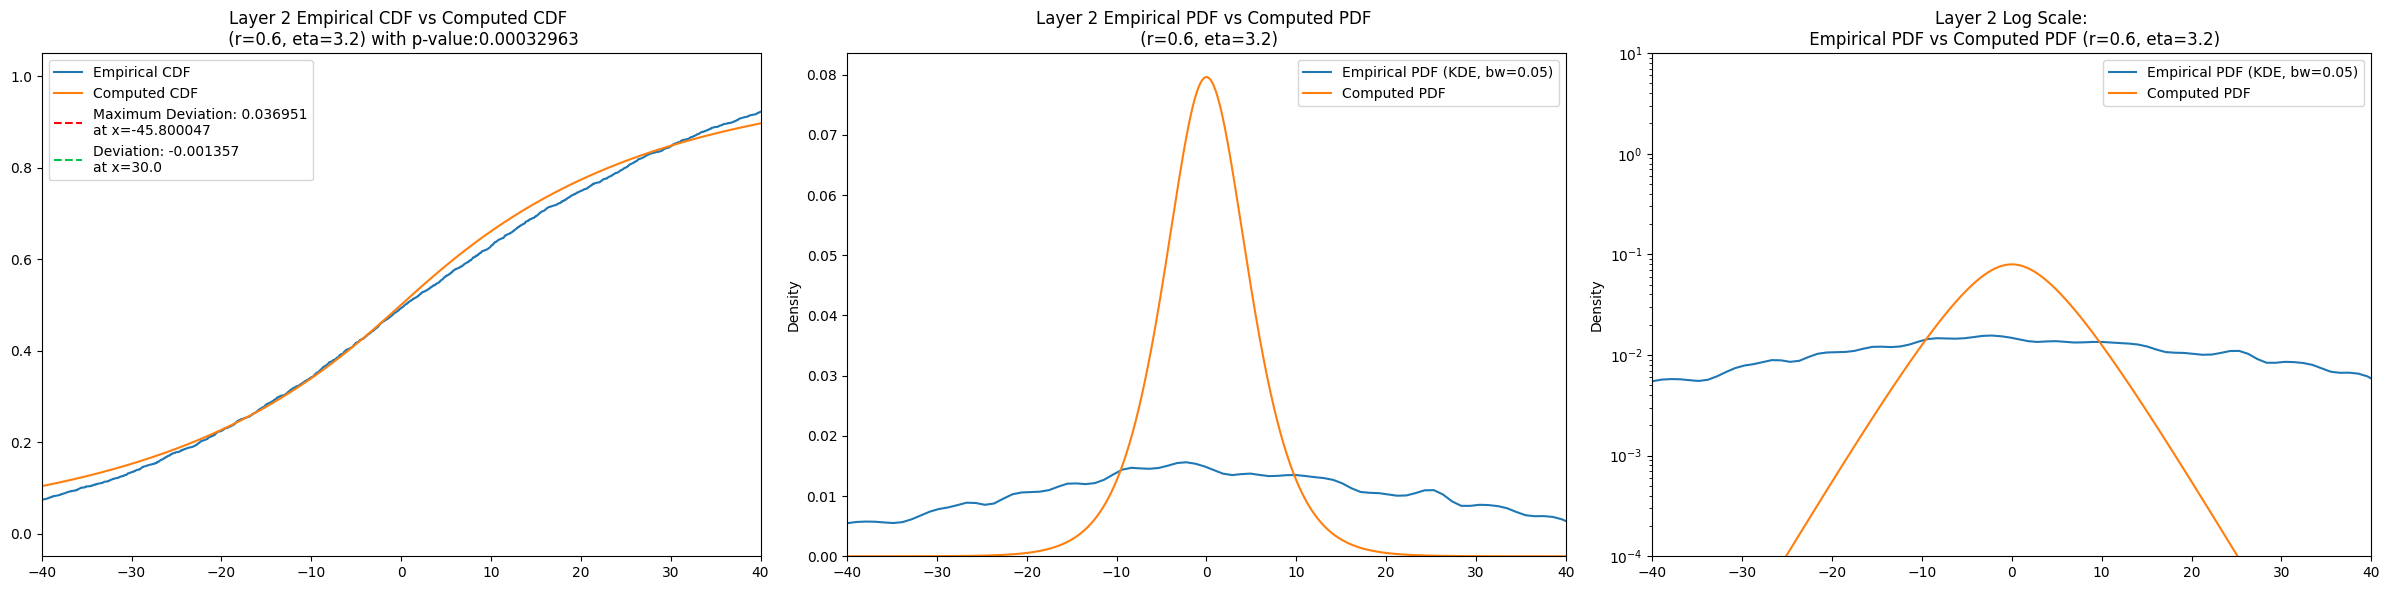

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:87: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]


KeyboardInterrupt: 

In [15]:
for group in np.arange(min_group, max_group+1):
    group_info = master_df.loc[group]
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (group_info[f'best_r_d{r_d}'], group_info[f'best_eta_d{eta_d}']), 
                    log_scale = True,
                    all_cdfs = combine_pickles(f'{GROUP}{group}_10000'),
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(f'{DATA_NAME}/plots/compare_cdf_pdf_layer_{group}.png', bbox_inches = 'tight')

## Comparing with Gaussian and Laplace

In [17]:
def coord_descent_scipy(sample, initial_param):
    '''
    '''
    r_0, eta_0 = initial_param
    find_r_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_0), method = 'bounded', bounds = (max(0.5, r_0-0.1), r_0+0.1))
    r_1 = find_r_1['x']
    find_eta_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_eta', r_1), method = 'bounded', bounds = (max(0, eta_0-0.1), eta_0+0.1))
    eta_1 = find_eta_1['x']
    find_r_2 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_1), method = 'bounded', bounds = (max(0.5, r_1-0.1), r_1+0.1))

    r_2 = find_r_2['x']

    return r_2, eta_1, find_r_2['fun']

for layer in np.arange(min_group, max_group+1):
    master_df.loc[layer, f'best_r_scipy'], master_df.loc[layer, f'best_eta_scipy'], master_df.loc[layer, f'kstest_stat_cd_scipy'] = coord_descent_scipy(group_data_map[layer], master_df.loc[layer, 'initial_param'])

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv', index_col = 'layer')
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df


KeyboardInterrupt: 

In [18]:
for group in np.arange(min_group, max_group+1):
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(min(master_df.loc[group, 'kstest_stat_cd'], master_df.loc[group, 'kstest_stat_cd_scipy'])), 6)

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

KeyboardInterrupt: 

# Examining Tail Behavior

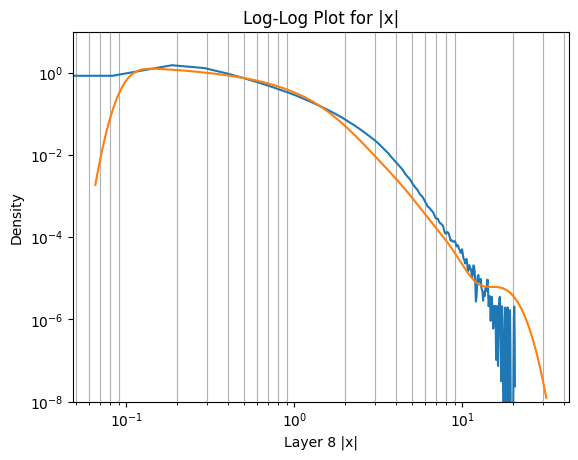

In [ ]:
bw = 0.1
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_7.png', bbox_inches = 'tight')

bw = 0.2
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_8.png', bbox_inches = 'tight')


In [ ]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[master_df.loc[layer, 'initial_param']]
            elif distro == 'gaussian':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for layer in np.arange(min_group, max_group+1):
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))


master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df.csv', index_col = 'layer')
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta_0,kstest_stat_cutoff_0.05,best_r_d3,best_eta_d2,kstest_stat_cd,n_pval_0.05,...,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,,,,,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709,0.024030,0.602,3.20,0.036033,1341,...,"(0.023188, 1.0344)","(0.023188, 1.0344)","(0.9368, 1.9545)","(0.9368, 1.9545)","(0.95089, 7.3557)","(0.95089, 7.3557)","(0.015521, 1.04)","(0.015521, 1.04)",0.038340,3.834015e-02
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739,0.012029,0.705,3.60,0.019689,4770,...,"(0.026952, 1.0742)","(0.026952, 1.0706)","(0.96671, 76.943)","(0.96671, 76.943)","(0.96151, 2839.9)","(0.96151, 2839.9)","(0.0074015, 1.1147)","(0.0074015, 1.1147)",0.020230,1.802446e-02
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078,0.006018,0.803,3.00,0.010263,16098,...,"(0.035397, 1.0105)","(0.035397, 1.0089)","(0.93633, 391120.0)","(0.97872, 391120.0)","(0.95756, 119260000.0)","(0.95756, 119260000.0)","(0.003275, 1.0744)","(0.003275, 1.0176)",0.011666,1.166561e-02
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301,0.003010,0.901,1.60,0.003025,203520,...,"(0.17436, 5225.2)","(0.17436, 5225.2)","(0.90723, 9.236e+34)","(0.98075, 9.236e+34)","(0.95007, 9.254e+46)","(0.97884, 9.254e+46)","(0.0034259, 1.0662)","(0.0034259, 1.0104)",0.003225,3.224737e-03
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370,0.001505,1.030,0.33,0.003651,128142,...,"(0.70499, 73248.0)","(0.70499, 73248.0)","(0.87957, 3.725e+56)","(0.99905, 3.725e+56)","(0.93638, 2.5142e+75)","(0.99905, 2.5142e+75)","(0.0013751, 1.2182)","(0.0013751, 1.0041)",0.002969,2.612471e-04
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895,0.000753,4.630,0.00,0.024877,3016,...,"(0.92184, 1911800000.0)","(0.99998, 83877.0)","(0.85009, 2.0712000000000005e+268)","(0.99998, 2.0712000000000005e+268)","(0.90639, inf)","(0.99998, inf)","(0.0015714, 1.506)","(0.0015714, 1.0007)",0.018187,2.426023e-05
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259,0.000376,5.700,0.00,0.171259,60,...,"(0.19852, 41045000.0)","(1.0, 3823.9)","(0.83652, inf)","(1.0, inf)","(0.89531, inf)","(1.0, inf)","(0.0028504, 1.7139)","(0.0028504, 1.0001)",0.004163,7.676389e-07


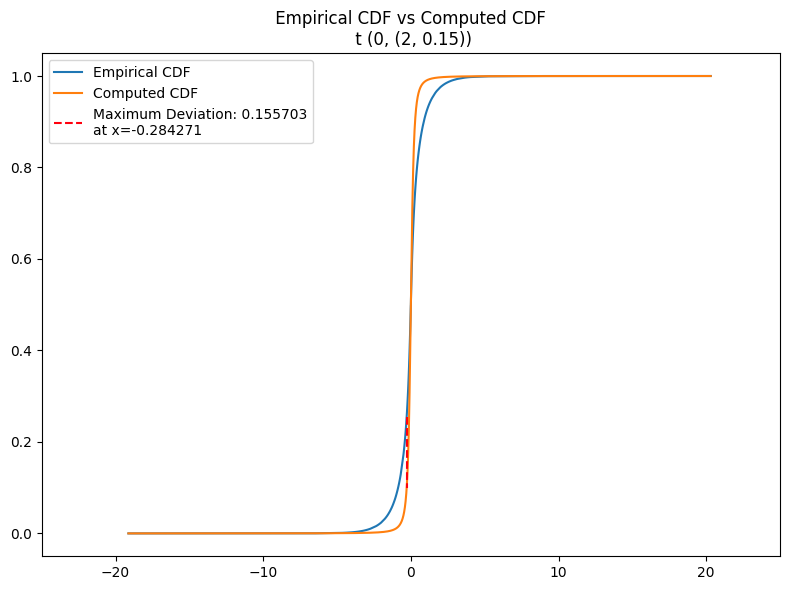

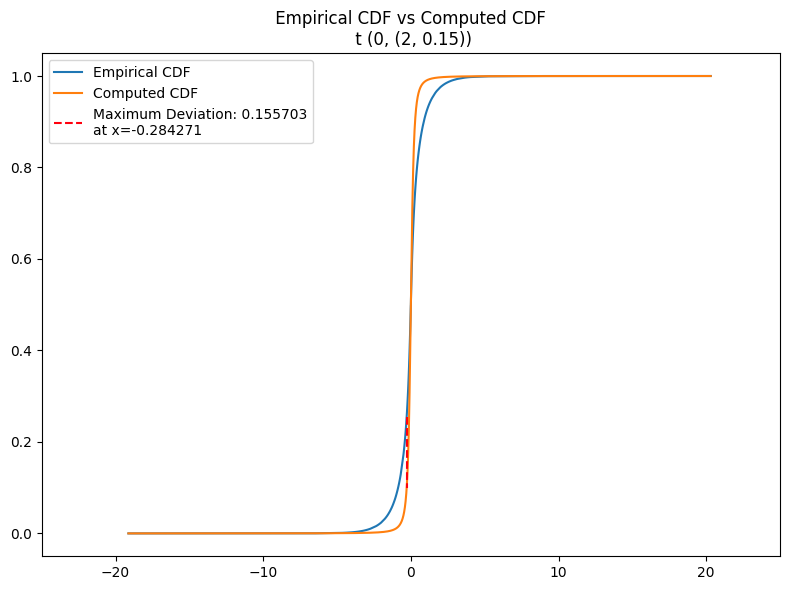

In [19]:
visualize_cdf(group_data_map[7], params=(2, 0.15), distro='t')

In [ ]:
#master_df.filter(regex='num_samples|kstest_stat.*')
# master_df.filter(regex='num_samples|best.*')
# master_df.filter(regex='.*gaussian')
#master_df#.filter(regex='kstest_pval.*')
master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,
2,"(0.023188, 1.0344)","(0.023188, 1.0344)","(0.9368, 1.9545)","(0.9368, 1.9545)","(0.95089, 7.3557)","(0.95089, 7.3557)","(0.015521, 1.04)","(0.015521, 1.04)",0.038340,3.834015e-02
3,"(0.026952, 1.0742)","(0.026952, 1.0706)","(0.96671, 76.943)","(0.96671, 76.943)","(0.96151, 2839.9)","(0.96151, 2839.9)","(0.0074015, 1.1147)","(0.0074015, 1.1147)",0.020230,1.802446e-02
4,"(0.035397, 1.0105)","(0.035397, 1.0089)","(0.93633, 391120.0)","(0.97872, 391120.0)","(0.95756, 119260000.0)","(0.95756, 119260000.0)","(0.003275, 1.0744)","(0.003275, 1.0176)",0.011666,1.166561e-02
5,"(0.17436, 5225.2)","(0.17436, 5225.2)","(0.90723, 9.236e+34)","(0.98075, 9.236e+34)","(0.95007, 9.254e+46)","(0.97884, 9.254e+46)","(0.0034259, 1.0662)","(0.0034259, 1.0104)",0.003225,3.224737e-03
6,"(0.70499, 73248.0)","(0.70499, 73248.0)","(0.87957, 3.725e+56)","(0.99905, 3.725e+56)","(0.93638, 2.5142e+75)","(0.99905, 2.5142e+75)","(0.0013751, 1.2182)","(0.0013751, 1.0041)",0.002969,2.612471e-04
7,"(0.92184, 1911800000.0)","(0.99998, 83877.0)","(0.85009, 2.0712000000000005e+268)","(0.99998, 2.0712000000000005e+268)","(0.90639, inf)","(0.99998, inf)","(0.0015714, 1.506)","(0.0015714, 1.0007)",0.018187,2.426023e-05
8,"(0.19852, 41045000.0)","(1.0, 3823.9)","(0.83652, inf)","(1.0, inf)","(0.89531, inf)","(1.0, inf)","(0.0028504, 1.7139)","(0.0028504, 1.0001)",0.004163,7.676389e-07


In [1]:
visualize_cdf(obs_x_dict[7], params=0.15, distro='t')

NameError: name 'visualize_cdf' is not defined